# Importing libraries

In [16]:
import xgboost as xgb
import talib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import scale
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Starting data and visualizatioin

In [4]:
df = yf.download('AAPL', start='2010-01-01', end='2024-01-01')
df.columns = df.columns.droplevel(1) 
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
2010-01-05,6.451465,6.487878,6.417459,6.458086,601904800
2010-01-06,6.348847,6.477046,6.342226,6.451466,552160000
2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
2010-01-08,6.379241,6.379843,6.291368,6.328683,447610800


Price,Close,High,Low,Open,Volume
count,3522.000000,3522.000000,3522.000000,3522.000000,3.522000e+03
mean,57.574681,58.154507,56.940304,57.532586,2.422834e+08
std,55.520111,56.088908,54.889501,55.463714,2.204578e+08
min,5.779475,5.898344,5.725306,5.789106,2.404830e+07
25%,16.948889,17.103421,16.785683,16.966750,9.266760e+07
50%,29.039495,29.255422,28.786081,29.039402,1.526602e+08
75%,88.776255,90.046457,88.015227,88.781723,3.284715e+08
max,196.927673,198.428656,195.824294,196.838214,1.880998e+09


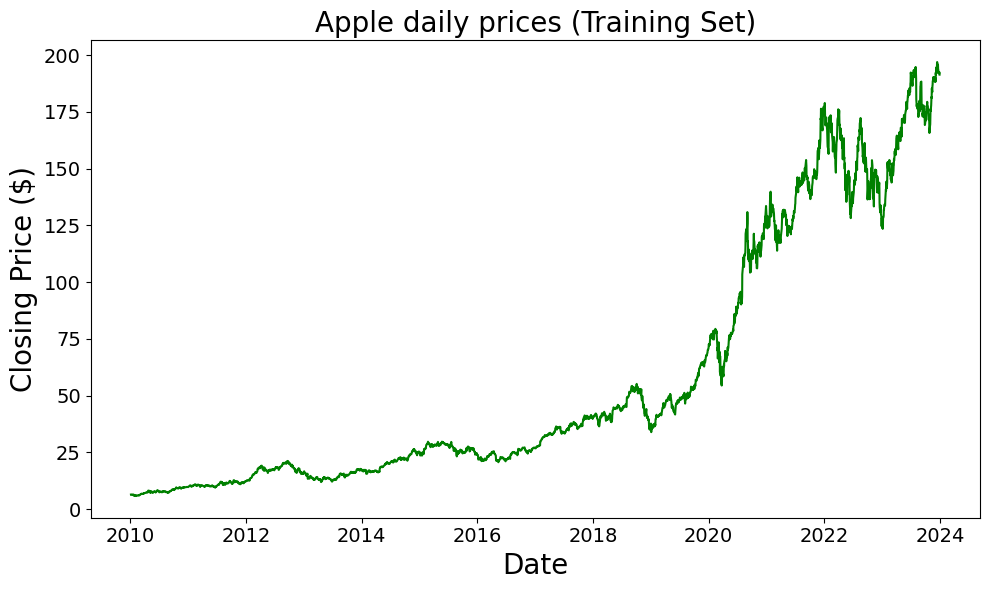

In [5]:
plt.figure(figsize=(10,6))
plt.plot(
  df.index,
  df['Close'],
  #label="Close Price ($)",
  color="green"
)
#plt.legend(fontsize=18, loc="upper left")
plt.yticks(fontsize=14)
plt.xlabel("Date", fontsize=20)
plt.xticks(fontsize=14)
plt.ylabel("Closing Price ($)", fontsize=20)
plt.title("Apple daily prices (Training Set)", fontsize=20)
plt.tight_layout()
df.describe()

# Feature engineering
Since XGBoost is essentially an ensemble algorithm based on decision trees, feature normalization is not required. That being said, I will include a couple of technical indicators.

The XGBoost library can also be used for both regression and classification. In this example, I will use it for classification.

In [6]:
# Moving Averages (Momentum Indicator)
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Relative Strength Index (Momentum Indicator)
df['RSI07'] = talib.RSI(df['Close'].values, timeperiod=7)
df['RSI14'] = talib.RSI(df['Close'].values, timeperiod=14)
df['RSI21'] = talib.RSI(df['Close'].values, timeperiod=21)

# Lagged Returns (Momentum-based Feature)
df['Return_1D'] = df['Close'].pct_change()  # Daily return
df['Return_5D'] = df['Close'].pct_change(periods=5)  # 5-day return
df['Return_10D'] = df['Close'].pct_change(periods=10)  # 10-day return

# Classification target (up/down)
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

df.dropna(inplace=True)
df.head()

Price,Close,High,Low,Open,Volume,MA10,MA50,MA200,RSI07,RSI14,RSI21,Return_1D,Return_5D,Return_10D,Target
Date,,,,,,,,,,,,,,,
2010-10-18,9.569766,9.599859,9.458118,9.583910,1093010800,8.999521,8.139175,7.387423,91.431340,83.388401,77.974092,0.010358,0.076652,0.141258,0
2010-10-19,9.313667,9.442468,9.028681,9.130398,1232784000,9.061363,8.167908,7.401790,67.155918,70.061848,69.024644,-0.026761,0.036678,0.071122,1
2010-10-20,9.344969,9.456917,9.234827,9.298926,721624400,9.125583,8.198676,7.416257,68.354023,70.678640,69.474278,0.003361,0.034618,0.073792,0
2010-10-21,9.314572,9.471661,9.232717,9.400038,551460000,9.186673,8.234385,7.431086,65.641216,69.187952,68.460990,-0.003253,0.023850,0.070189,0
2010-10-22,9.252877,9.330218,9.217668,9.301026,372778000,9.226999,8.267898,7.445665,60.002283,66.138880,66.397154,-0.006624,-0.023099,0.045567,1


/tmp/ipykernel_2951/1860697180.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=18)


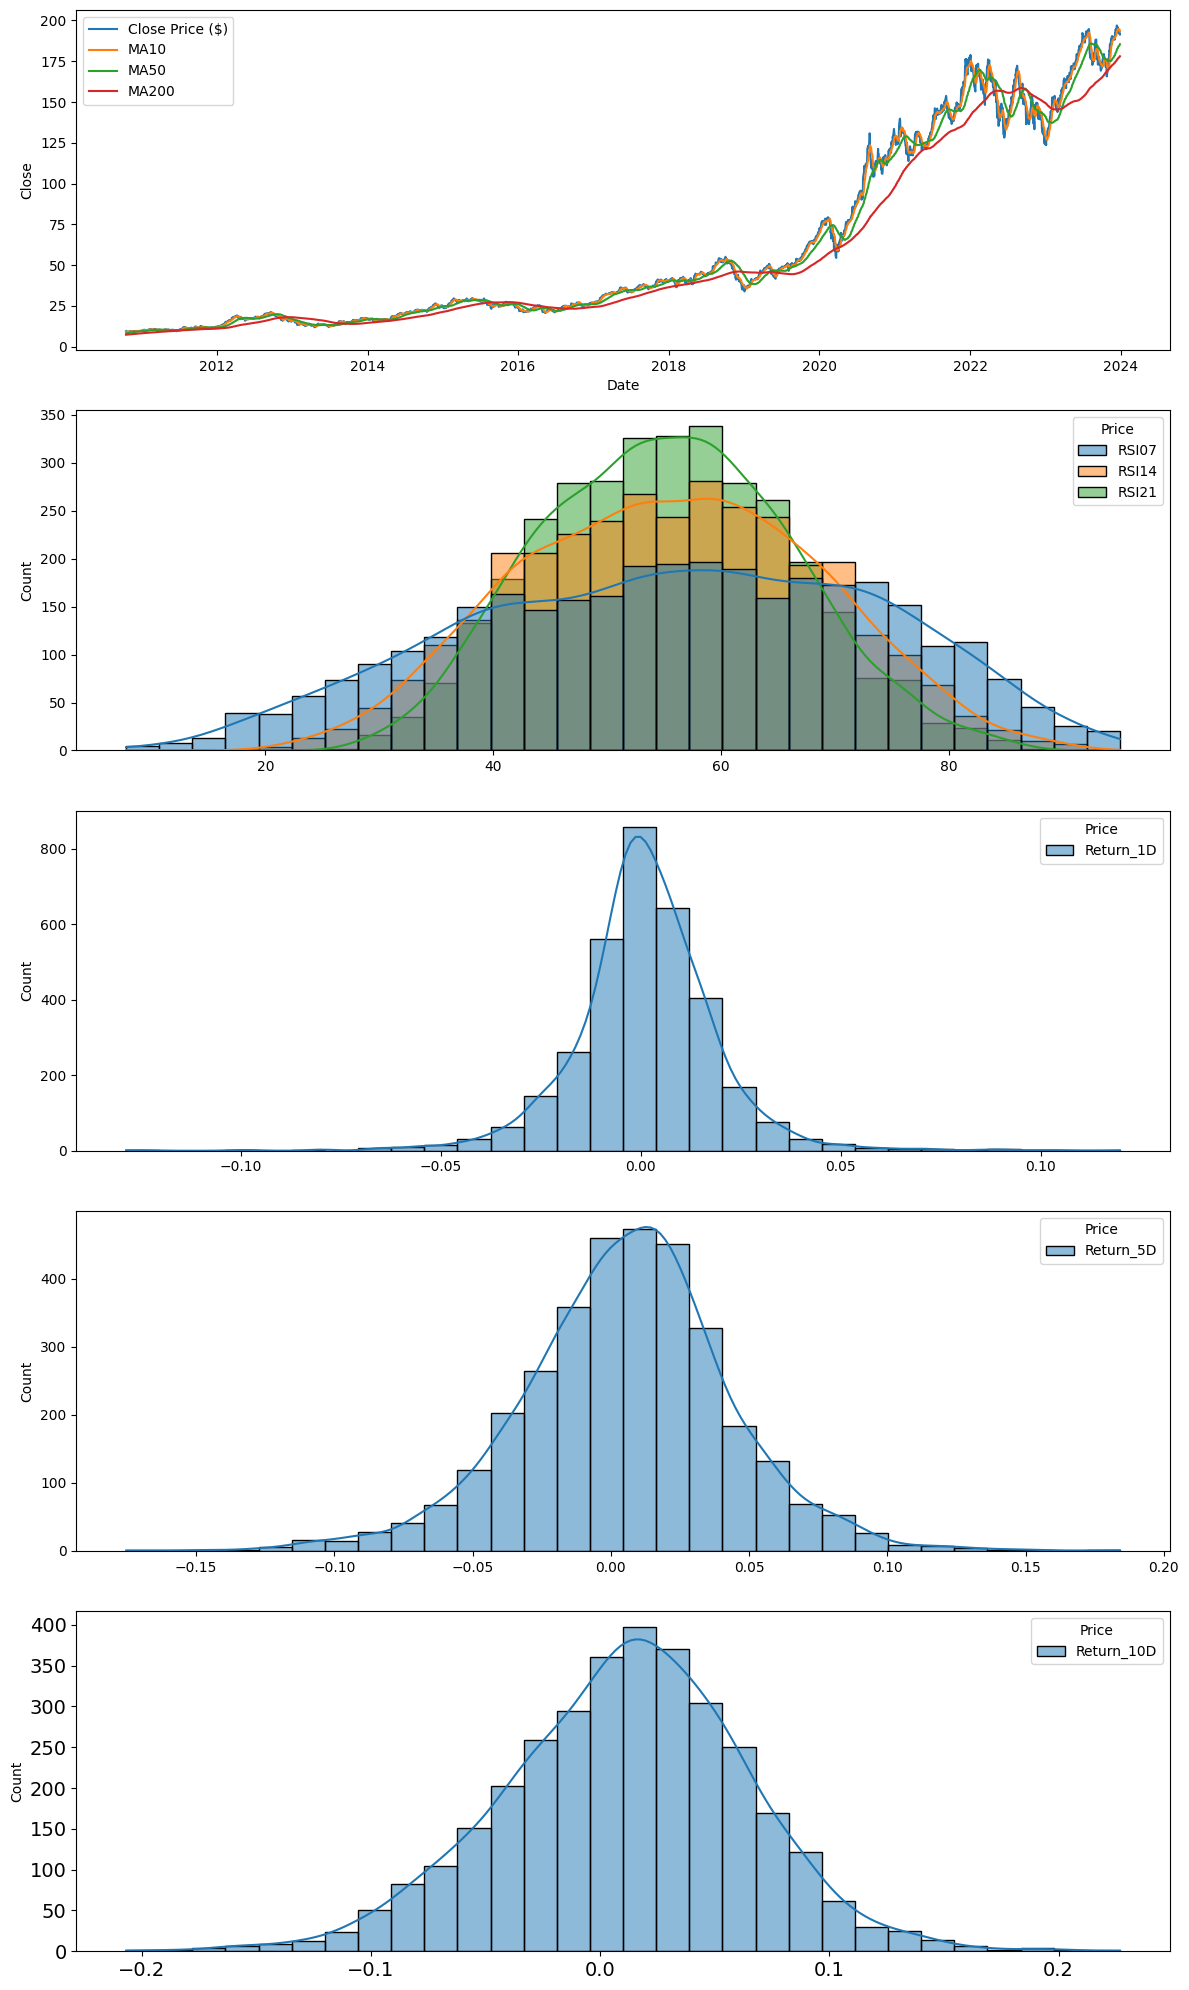

In [47]:
#fig, ax = plt.subplots(3,2,figsize=(12, 8), gridspec_kw={'height_ratios': [4, 2,1], 'width_ratios': [2, 1]})
fig, ax = plt.subplots(5,1,figsize=(12, 20))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
sns.lineplot(x=df.index, y=df['Close'], label='Close Price ($)', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA10'], label='MA10', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA50'], label='MA50', ax=ax[0])
sns.lineplot(x=df.index, y=df['MA200'], label='MA200', ax=ax[0])

#fig.delaxes(ax[0,1])

sns.histplot(df[['RSI07', 'RSI14', 'RSI21']], bins=30, kde=True, ax=ax[1])
sns.histplot(df[['Return_1D']], bins=30, kde=True, ax=ax[2])
sns.histplot(df[['Return_5D']], bins=30, kde=True, ax=ax[3])
sns.histplot(df[['Return_10D']], bins=30, kde=True, ax=ax[4])


plt.tight_layout()

Interestingly enough, the longer the period of the RSI, the closer it is to a normal distribution. RSI and N-day returns all correspond to a positively skewed bell curve, originating from the fact that Apple stocks have been extremely lucrative over the years. Another small takeaway is that holdoing for 1 day only is most likely harmful, though that should be common sense, since we aren't even taking into account transactional costs, which move around 0.25%

In [ ]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'MA10', 'MA50', 'MA200',
       'RSI14', 'RSI07', 'RSI21', 'Return_1D', 'Return_5D', 'Return_10D']
X = df[features]
y = df['Target']

X = pd.DataFrame(scale(X), index=X.index, columns=X.columns) # Scaling features just to be safe
y.value_counts()
X.describe()

Price,Close,High,Low,Open,Volume,MA10,MA50,MA200,RSI14,RSI07,RSI21,Return_1D,Return_5D,Return_10D
count,3323.000000,3.323000e+03,3.323000e+03,3.323000e+03,3.323000e+03,3323.000000,3323.000000,3.323000e+03,3.323000e+03,3.323000e+03,3.323000e+03,3.323000e+03,3.323000e+03,3.323000e+03
mean,0.000000,-1.368484e-16,1.368484e-16,-1.368484e-16,-3.421211e-17,0.000000,0.000000,-6.842422e-17,4.832460e-16,-6.200945e-17,4.490339e-17,1.069128e-17,-3.100472e-17,4.490339e-17
std,1.000151,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151,1.000151,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00,1.000151e+00
min,-0.924725,-9.243001e-01,-9.247768e-01,-9.244866e-01,-1.005211e+00,-0.924536,-0.935565,-9.304085e-01,-2.647076e+00,-2.692206e+00,-2.581221e+00,-7.311944e+00,-4.767442e+00,-4.066798e+00
25%,-0.753363,-7.532464e-01,-7.523557e-01,-7.531579e-01,-6.631266e-01,-0.752791,-0.756133,-7.388516e-01,-7.438877e-01,-7.663270e-01,-7.448991e-01,-4.837442e-01,-5.967857e-01,-6.308207e-01
50%,-0.476746,-4.790906e-01,-4.752620e-01,-4.776850e-01,-3.918179e-01,-0.476593,-0.463869,-5.143141e-01,1.929932e-03,3.818292e-02,-3.619632e-03,-9.840066e-03,3.490446e-02,4.306504e-02
75%,0.920801,9.221383e-01,9.076282e-01,9.178631e-01,3.378821e-01,0.908885,0.851593,4.905704e-01,7.248939e-01,7.903134e-01,6.947426e-01,5.228003e-01,5.940324e-01,6.615529e-01
max,2.446428,2.437413e+00,2.466689e+00,2.448127e+00,8.611476e+00,2.421631,2.317655,2.379367e+00,2.700183e+00,2.202215e+00,2.897978e+00,6.693896e+00,4.719891e+00,4.037737e+00


# Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Shuffle=False since stocks are time series data

# XGBoost uses DMatrix instead of numpy arrays
train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

# XGBoost parameters for binary classification
params = {
#    "objective": "binary:logistic",  # Binary classification
#    "eval_metric": "logloss",
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5,6,7],
    "n_estimators": [100,200,500]
}


# Fitting model

[0]	Test-logloss:0.69263


/home/martin/projects/Geometric_DataAnalysis/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	Test-logloss:0.84949
[101]	Test-logloss:0.84946
Accuracy: 0.4827
              precision    recall  f1-score   support

           0       0.48      0.88      0.62       317
           1       0.52      0.12      0.20       348

    accuracy                           0.48       665
   macro avg       0.50      0.50      0.41       665
weighted avg       0.50      0.48      0.40       665

Strategy cumulative returns: 1.0340390392222665
Buy-hold cumulative returns: 1.5511570069424787
[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0

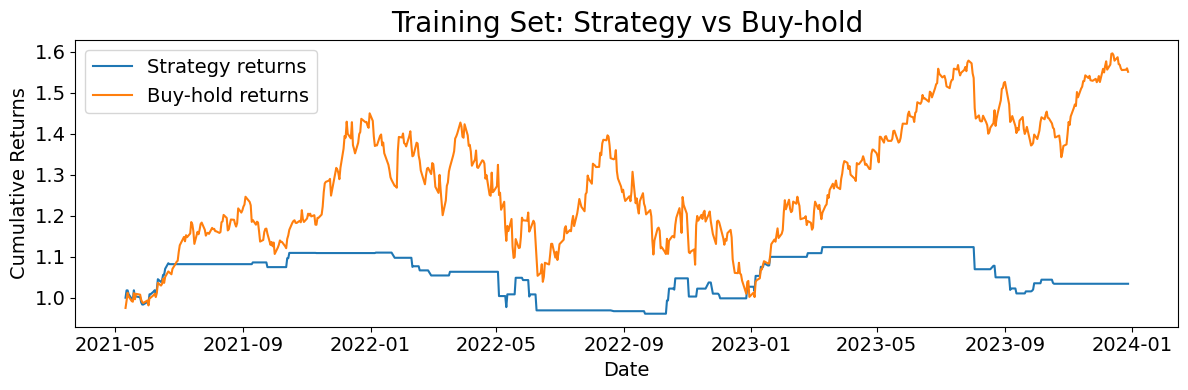

In [26]:
params = {
    "objective": "binary:logistic",  # Binary classification
    "eval_metric": "logloss",
    "learning_rate": 0.1,
    "max_depth": 6,
    "n_estimators": 500
}
model = xgb.train(params, train_data, num_boost_round=1000, evals=[(test_data, "Test")], early_stopping_rounds=100, verbose_eval=100)

# Make predictions
y_test_pred = model.predict(test_data)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convert probabilities to 0 or 1

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(classification_report(y_test, y_test_pred))

strategy_cumulative_returns = (1 + X_test['Return_1D'].shift(-1) * y_test_pred).cumprod()
buy_hold_cumulative_returns = (1 + X_test['Return_1D'].shift(-1)).cumprod()

fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(x=X_test.index, y=strategy_cumulative_returns, label='Strategy returns', ax=ax)
sns.lineplot(x=X_test.index, y=buy_hold_cumulative_returns, label='Buy-hold returns', ax=ax)
plt.title('Training Set: Strategy vs Buy-hold', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Returns', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()

print(f"Strategy cumulative returns: {strategy_cumulative_returns.iloc[-2]}")
print(f"Buy-hold cumulative returns: {buy_hold_cumulative_returns.iloc[-2]}")
strategy_cumulative_returns.describe()
print(y_train_pred)

Sadly this model is also just slightly better than random guessing

/tmp/ipykernel_47610/374250718.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


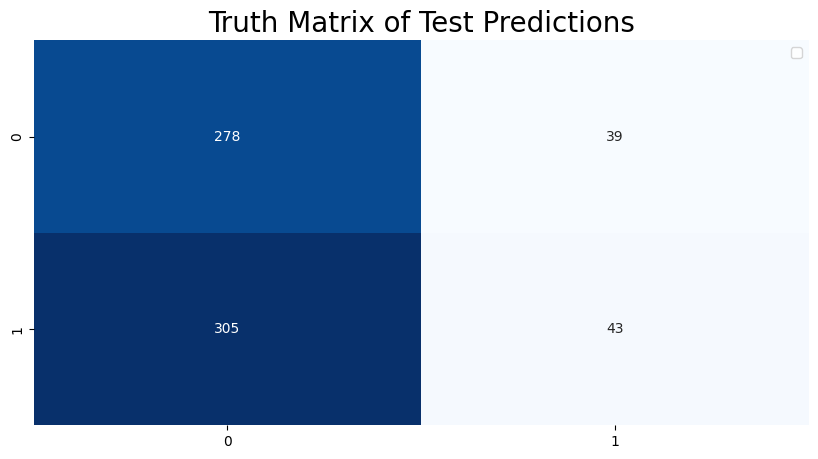

In [27]:
plt.figure(figsize=(10,5))
cm = confusion_matrix(y_test.values, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Truth Matrix of Test Predictions", fontsize=20)

plt.legend()
plt.show()


Overall accuracy of ~48%. The model definitely needs more tuning.